In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/map-charting-student-math-misunderstandings/sample_submission.csv
/kaggle/input/map-charting-student-math-misunderstandings/train.csv
/kaggle/input/map-charting-student-math-misunderstandings/test.csv
/kaggle/input/gemma2-9b-it-bf16/model.safetensors.index.json
/kaggle/input/gemma2-9b-it-bf16/model-00003-of-00004.safetensors
/kaggle/input/gemma2-9b-it-bf16/config.json
/kaggle/input/gemma2-9b-it-bf16/model-00001-of-00004.safetensors
/kaggle/input/gemma2-9b-it-bf16/tokenizer.json
/kaggle/input/gemma2-9b-it-bf16/tokenizer_config.json
/kaggle/input/gemma2-9b-it-bf16/__huggingface_repos__.json
/kaggle/input/gemma2-9b-it-bf16/chat_template.jinja
/kaggle/input/gemma2-9b-it-bf16/model-00004-of-00004.safetensors
/kaggle/input/gemma2-9b-it-bf16/special_tokens_map.json
/kaggle/input/gemma2-9b-it-bf16/model-00002-of-00004.safetensors
/kaggle/input/gemma2-9b-it-bf16/tokenizer.model
/kaggle/input/gemma2-9b-it-bf16/generation_config.json
/kaggle/input/gemma2-9b-it-cv945/adapter_model.sa

## Environment Setup and Directory Initialization


In [2]:
# Import the OS module to interact with the operating system
import os

# Specify which GPUs to make visible (GPU 0 and 1 in this case)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Version identifier for this run or experiment
VER = 1

# Model name (either use a predefined Hugging Face model or a local checkpoint)
# model_name = "google/gemma-2-9b-it"  # Uncomment this to use the Hugging Face version
model_name = "/kaggle/input/gemma2-9b-it-cv945"  # Path to the local model

# Number of training epochs
EPOCHS = 2

# Create a directory named after the version (e.g., "ver_1")
DIR = f"ver_{VER}"
os.makedirs(DIR, exist_ok=True)


## Data Loading and Label Encoding


In [3]:
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/train.csv')
train.Misconception = train.Misconception.fillna('NA')
train['target'] = train.Category+":"+train.Misconception
train['label'] = le.fit_transform(train['target'])
target_classes = le.classes_
n_classes = len(target_classes)
print(f"Train shape: {train.shape} with {n_classes} target classes")
train.head()


Train shape: (36696, 9) with 65 target classes


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,Category,Misconception,target,label
0,0,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),0ne third is equal to tree nineth,True_Correct,NA,True_Correct:NA,37
1,1,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 / 3 because 6 over 9 is 2 thirds and 1 third...,True_Correct,NA,True_Correct:NA,37
2,2,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"1 3rd is half of 3 6th, so it is simplee to un...",True_Neither,NA,True_Neither:NA,64
3,3,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 goes into everything and 3 goes into nine,True_Neither,NA,True_Neither:NA,64
4,4,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),1 out of every 3 isn't coloured,True_Correct,NA,True_Correct:NA,37


## Identify Correct Answers and Merge with Training Data


In [4]:

idx = train.apply(lambda row: row.Category.split('_')[0],axis=1)=='True'
correct = train.loc[idx].copy()
correct['c'] = correct.groupby(['QuestionId','MC_Answer']).MC_Answer.transform('count')
correct = correct.sort_values('c',ascending=False)
correct = correct.drop_duplicates(['QuestionId'])
correct = correct[['QuestionId','MC_Answer']]
correct['is_correct'] = 1

train = train.merge(correct, on=['QuestionId','MC_Answer'], how='left')
train.is_correct = train.is_correct.fillna(0)

## Display Question Text with Ranked Answer Choices


In [5]:

from IPython.display import display, Math, Latex

# GET ANSWER CHOICES
tmp = train.groupby(['QuestionId','MC_Answer']).size().reset_index(name='count')
tmp['rank'] = tmp.groupby('QuestionId')['count'].rank(method='dense', ascending=False).astype(int) - 1
tmp = tmp.drop('count',axis=1)
tmp = tmp.sort_values(['QuestionId','rank'])

# DISPLAY QUESTION AND ANSWER CHOICES
Q = tmp.QuestionId.unique()
for q in Q:
    question = train.loc[train.QuestionId==q].iloc[0].QuestionText
    choices = tmp.loc[tmp.QuestionId==q].MC_Answer.values
    labels="ABCD"
    choice_str = " ".join([f"({labels[i]}) {choice}" for i, choice in enumerate(choices)])
    
    print()
    display(Latex(f"QuestionId {q}: {question}") )
    display(Latex(f"MC Answers: {choice_str}"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Tokenizer Setup and Configuration


In [6]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

# Load tokenizer from the specified model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set maximum token length for inputs
MAX_LEN = 256


## Create Formatted Text Prompts for the Model


In [7]:
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np

tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_LEN = 256

In [8]:
def format_input(row):
    x = "Yes"
    if not row['is_correct']:
        x = "No"
    return (
        f"Question: {row['QuestionText']}\n"
        f"Answer: {row['MC_Answer']}\n"
        f"Correct? {x}\n"
        f"Student Explanation: {row['StudentExplanation']}"
    )

train['text'] = train.apply(format_input,axis=1)
print("Example prompt for our LLM:")
print()
print( train.text.values[0] )

Example prompt for our LLM:

Question: What fraction of the shape is not shaded? Give your answer in its simplest form. [Image: A triangle split into 9 equal smaller triangles. 6 of them are shaded.]
Answer: \( \frac{1}{3} \)
Correct? Yes
Student Explanation: 0ne third is equal to tree nineth


## Token Length Distribution


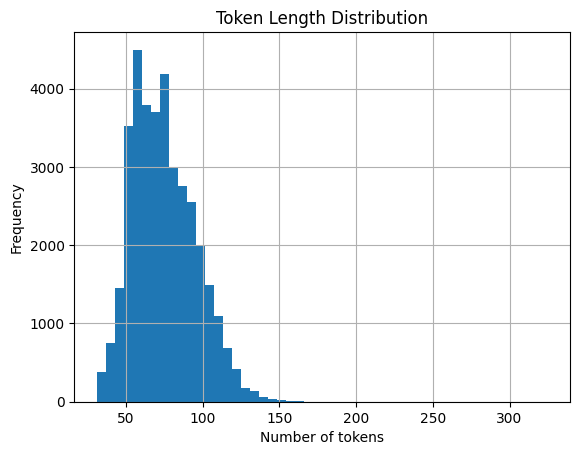

In [9]:
lengths = [len(tokenizer.encode(t, truncation=False)) for t in train["text"]]
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [10]:
L = (np.array(lengths)>MAX_LEN).sum()
print(f"There are {L} train sample(s) with more than {MAX_LEN} tokens")
np.sort( lengths )

There are 1 train sample(s) with more than 256 tokens


array([ 31,  31,  31, ..., 195, 231, 325])

## Train-Validation Split and Dataset Conversion


In [11]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
# Split into train and validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Convert to Hugging Face Dataset
COLS = ['text','label']
train_ds = Dataset.from_pandas(train_df[COLS])
val_ds = Dataset.from_pandas(val_df[COLS])

## Tokenize Datasets and Prepare for PyTorch


In [12]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Set format for PyTorch
columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

Map:   0%|          | 0/29356 [00:00<?, ? examples/s]

Map:   0%|          | 0/7340 [00:00<?, ? examples/s]

## Load Pretrained Model for Sequence Classification


In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/gemma2-9b-it-bf16",
    num_labels=n_classes,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

2025-07-27 06:37:51.275464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753598271.466297      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753598271.518482      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of Gemma2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/gemma2-9b-it-bf16 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Load PEFT Adapter


In [14]:
from peft import PeftModel

# Load PEFT model adapter on top of the base model
model = PeftModel.from_pretrained(
    model,        # Base model (already loaded above)
    model_name    # Path or name of the PEFT adapter
)


/usr/local/lib/python3.11/dist-packages/peft/config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


## Training Arguments Configuration


In [15]:
training_args = TrainingArguments(
    output_dir = f"./{DIR}",
    do_train=True,
    do_eval=True,
    eval_strategy="steps",
    save_strategy="steps", #no for no saving 
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=200,
    eval_steps=200,
    save_total_limit=1,
    metric_for_best_model="map@3",
    greater_is_better=True,
    load_best_model_at_end=True,
    report_to="none",
    bf16=False, # TRAIN WITH BF16 IF LOCAL GPU IS NEWER GPU          
    fp16=True, # INFER WITH FP16 BECAUSE KAGGLE IS T4 GPU
)

## Custom MAP@3 Metric


In [16]:
#  CUSTOM MAP@3 METRIC

from sklearn.metrics import average_precision_score

def compute_map3(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
    
    top3 = np.argsort(-probs, axis=1)[:, :3]  # Top 3 predictions
    match = (top3 == labels[:, None])

    # Compute MAP@3 manually
    map3 = 0
    for i in range(len(labels)):
        if match[i, 0]:
            map3 += 1.0
        elif match[i, 1]:
            map3 += 1.0 / 2
        elif match[i, 2]:
            map3 += 1.0 / 3
    return {"map@3": map3 / len(labels)}

## Trainer Setup and Model Training


In [17]:
import torch
import accelerate
print(torch.__version__)
print(accelerate.__version__)
print(torch.cuda.is_bf16_supported())


2.6.0+cu124
1.8.1
True


In [18]:
torch.set_float32_matmul_precision('high')  # ensures fp16 matmuls are used where possible
torch.backends.cuda.matmul.allow_bf16_reduced_precision_reduction = False
torch.backends.cuda.matmul.allow_tf32 = False  # If needed


In [19]:
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_map3,
)

#trainer.train()

/tmp/ipykernel_19/661334471.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## Load and Inspect Test Dataset


In [20]:
# Load the test dataset
test = pd.read_csv('/kaggle/input/map-charting-student-math-misunderstandings/test.csv')

# Print the shape to see number of rows and columns
print(test.shape)

# Display the first few rows
test.head()


(3, 5)


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si..."
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.


## Merge Correct Answers with Test Data and Format Text Prompts


In [21]:
# Merge the 'correct' answers dataframe with the test set
test = test.merge(correct, on=['QuestionId', 'MC_Answer'], how='left')

# Fill missing values: rows without a match are marked as incorrect
test['is_correct'] = test['is_correct'].fillna(0)

# Create formatted text prompts for the test data
test['text'] = test.apply(format_input, axis=1)

# Display the first few rows to verify
test.head()


,row_id,QuestionId,QuestionText,MC_Answer,StudentExplanation,is_correct,text
0,36696,31772,What fraction of the shape is not shaded? Give...,\( \frac{1}{3} \),"I think that 1/3 is the answer, as it's the si...",1.0,Question: What fraction of the shape is not sh...
1,36697,31772,What fraction of the shape is not shaded? Give...,\( \frac{3}{6} \),i think this answer is because 3 triangles are...,0.0,Question: What fraction of the shape is not sh...
2,36698,32835,Which number is the greatest?,\( 6.2 \),because the 2 makes it higher than the others.,1.0,Question: Which number is the greatest?\nAnswe...


## Prepare Test Dataset, Run Predictions, and Compute Probabilities


In [22]:
# Convert test DataFrame to Hugging Face Dataset (keep only the 'text' column)
ds_test = Dataset.from_pandas(test[['text']])

# Apply tokenization to the test dataset
ds_test = ds_test.map(tokenize, batched=True)

# Run the trained model to get raw predictions (logits)
predictions = trainer.predict(ds_test)

# Convert logits to probabilities using softmax
probs = torch.nn.functional.softmax(
    torch.tensor(predictions.predictions), dim=1
).numpy()


Map:   0%|          | 0/3 [00:00<?, ? examples/s]

## Generate Top-3 Predictions and Create Submission File


In [23]:
 #Get top 3 predicted class indices
top3 = np.argsort(-probs, axis=1)[:, :3]   # shape: [num_samples, 3]

# Decode numeric class indices to original string labels
flat_top3 = top3.flatten()
decoded_labels = le.inverse_transform(flat_top3)
top3_labels = decoded_labels.reshape(top3.shape)

# Join 3 labels per row with space
joined_preds = [" ".join(row) for row in top3_labels]

# Save submission
sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "Category:Misconception": joined_preds
})
sub.to_csv("submission.csv", index=False)
sub.head()
print("submission.csv saved")


submission.csv saved
